# K-Neighbors Regressor

Your goal is to train a model to predict the bitterness of a beer (in International Bittering Units, or IBU), given features about the beer. You can acquire the data in any one of three places:

- on [Kaggle](https://www.kaggle.com/c/beer2019/data) 
- on [Github](https://github.com/dlsun/data-science-book/tree/master/data/beer)
- in the `/data301/data/beer/` directory

A description of the variables is available [here](https://www.kaggle.com/c/beer2019/data).

In [36]:
import pandas as pd, numpy as np
%matplotlib inline

beer_df = pd.read_csv("/data301/data/beer/beer_train.csv")
beer_df = beer_df.drop('id', axis=1)
beer_df.head()

,abv,available,description,glass,ibu,isOrganic,name,originalGravity,srm
0,8.2,"Available at the same time of year, every year.",A Belgian-Abbey-Style Tripel that is big in al...,NaN,31.0,N,LoonyToonTripel,1.070,8
1,5.7,"Available at the same time of year, every year.",Covert Hops is a crafty ale. Its stealthy dark...,Pint,45.0,N,Covert Hops,1.056,35
2,5.8,"Available at the same time of year, every year.",This is a traditional German-style Marzen char...,Mug,25.0,N,Oktoberfest,1.048,10
3,5.5,Available year round as a staple beer.,A West Coast-Style Pale Ale balancing plenty o...,Pint,55.0,N,Pale Ale,1.044,5
4,4.8,Available year round as a staple beer.,This Bombshell has a tantalizing crisp and cle...,Pint,11.4,N,Head Turner Blonde Ale,1.045,3


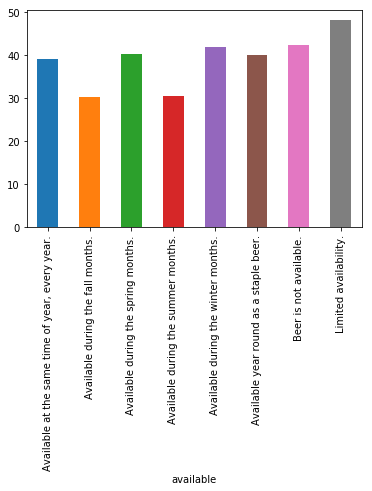

In [37]:
beer_df.groupby("available").ibu.mean().plot.bar()

The availability of the beer will matter (most of the time), since it is known that spring beers are typically more hoppy/bitter than winter beers, which are typically cripser/sweeter. Many of the beers that have limited availability are (from my experience) one-off or specialty brews that tend towards IPA's, DIPA's, NEIPA's, and more "hoppy" beers, as that is what is "popular" amongst the craft brew scene.

In [38]:
beer_df.ibu.describe()

count    6000.000000
mean       41.196877
std        28.846228
min         1.000000
25%        22.000000
50%        33.000000
75%        55.000000
max      1000.000000
Name: ibu, dtype: float64

In [39]:
beer_df.description = beer_df.description.fillna("")
beer_bitter = beer_df[beer_df.ibu >= 33]
beer_not_bitter = beer_df[beer_df.ibu < 33]

Looking at the description of beers (and names), we can try and evaulate whether or not there seems to be a correlation between the appearance of certain words in a description (and name) and the IBU of the beer.

In [40]:
# CREDIT: https://medium.com/@cristhianboujon/how-to-list-the-most-common-words-from-text-corpus-using-scikit-learn-dad4d0cab41d
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = ([(word, sum_words[0, idx]) 
                   for word, idx in vec.vocabulary_.items()])
    words_freq = sorted(words_freq, 
                        key = lambda x: x[1], reverse=True)
    words = [w_f[0] for w_f in words_freq]
    return words[:n]

This function uses scikit-learn to get the frequencies of words, I modified it a little bit to fit my purposes a little better

In [41]:
from sklearn.feature_extraction.text import CountVectorizer

bitter_words = get_top_n_words(
    beer_bitter.description.str.lower(), n=20)
not_bitter_words = get_top_n_words(
    beer_not_bitter.description.str.lower(), n=20)
list(set(bitter_words) & set(not_bitter_words))
bitter_words = ([word for word in bitter_words 
                 if word not in not_bitter_words])
not_bitter_words = ([word for word in not_bitter_words 
                     if word not in bitter_words])
print(bitter_words)
print(not_bitter_words)

['ipa', 'pale', 'american', 'dry', 'citrus', 'flavors', 'bitterness', 'chocolate']
['beer', 'ale', 'malt', 'hops', 'style', 'brewed', 'flavor', 'light', 'wheat', 'finish', 'malts', 'aroma', 'lager', 'hop', 'yeast', 'german', 'belgian', 'dark', 'sweet', 'refreshing']


In [42]:
get_same_words = lambda row, words : (
    len({word for word in words if word in row}))
beer_df["bitter_description_words"] = (
    beer_df.description.str.lower()
    .apply(get_same_words, words=bitter_words))
beer_df["not_bitter_description_words"] = (
    beer_df.description.str.lower()
    .apply(get_same_words, words=not_bitter_words))

... and repeat for name

In [43]:
bitter_words = (
    get_top_n_words(beer_bitter
                    .name.str.lower(), n=10))
not_bitter_words = (
    get_top_n_words(
        beer_not_bitter.name.str.lower(), n=10))
list(set(bitter_words) & set(not_bitter_words))
bitter_words = ([word for word in bitter_words 
                 if word not in not_bitter_words])
not_bitter_words = ([word for word in not_bitter_words 
                     if word not in bitter_words])
print(bitter_words)
print(not_bitter_words)

['ipa', 'pale', 'imperial', 'black', 'hop', 'double']
['ale', 'wheat', 'lager', 'porter', 'stout', 'brown', 'blonde', 'red', 'saison', 'amber']


In [44]:
beer_df["bitter_name_words"] = (
    beer_df.name.str.lower()
    .apply(get_same_words, words=bitter_words))
beer_df["not_bitter_name_words"] = (
    beer_df.name.str.lower()
    .apply(get_same_words, words=not_bitter_words))

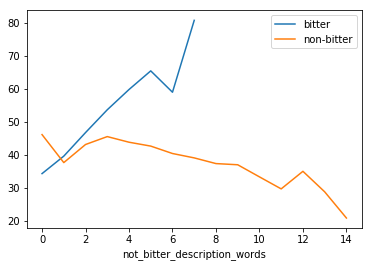

In [45]:
(beer_df.groupby("bitter_description_words")
 .ibu.mean().plot(label="bitter", legend=True))
(beer_df.groupby("not_bitter_description_words")
 .ibu.mean().plot(label="non-bitter", legend=True))

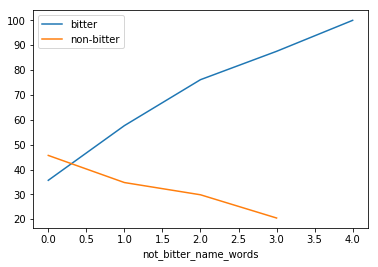

In [46]:
(beer_df.groupby("bitter_name_words")
 .ibu.mean().plot(label="bitter", legend=True))
(beer_df.groupby("not_bitter_name_words")
 .ibu.mean().plot(label="non-bitter", legend=True))

There does in fact appear to be some sort of relationship between the appearance of certain words in a beer description (and name) and its IBU. This may be a rough relationship, but it may be useful in the approximation of beers with similar descriptions (and names).

Below are miscellaneous steps to clean the data in preparation for how I will use it.

In [47]:
#beer_df.srm = beer_df.srm.replace(
#    {"Over 40": "40"}).astype(int)
beer_df.glass = beer_df.glass.fillna("Unknown")
beer_df = beer_df.drop(
    ["description", "name"], axis=1)
beer_df.head()

,abv,available,glass,ibu,isOrganic,originalGravity,srm,bitter_description_words,not_bitter_description_words,bitter_name_words,not_bitter_name_words
0,8.2,"Available at the same time of year, every year.",Unknown,31.0,N,1.070,8,2,5,0,0
1,5.7,"Available at the same time of year, every year.",Pint,45.0,N,1.056,35,0,7,1,0
2,5.8,"Available at the same time of year, every year.",Mug,25.0,N,1.048,10,1,8,0,0
3,5.5,Available year round as a staple beer.,Pint,55.0,N,1.044,5,1,5,1,1
4,4.8,Available year round as a staple beer.,Pint,11.4,N,1.045,3,0,4,0,2


# Question 1

Choose at least 5 different _sets_ of features that you think might be important. For example, three different sets of features might be:

- `abv`
- `abv`, `available`, `originalGravity`
- `originalGravity`, `srm`

(You do not have to use these sets of features. They are provided just as an example.)

For each set of features, train a $30$-nearest neighbor model to predict IBU (`ibu`). Determine which of these models is best at predicting IBU. Is it the model that contained the most features?

In [48]:
def combinations(lst):
    len_lst = len(lst)
    c = []
    for i in range(len_lst):
        tmp = []
        for j in range(i, len_lst):
            tmp.append(lst[j])
            c.append(tmp.copy())
    return c
combinations([1, 2, 3])

[[1], [1, 2], [1, 2, 3], [2], [2, 3], [3]]

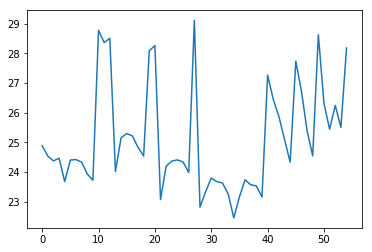

In [49]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

vec = DictVectorizer(sparse=False)
scaler = StandardScaler()
model = KNeighborsRegressor(n_neighbors=30)

def feature_set_cv_error(feature_set):
    X_dict = (beer_df.drop("ibu", axis=1)[feature_set]
              .to_dict(orient="records"))
    y = beer_df["ibu"]
    
    pipeline = Pipeline(
        [("vectorizer", vec), 
         ("scaler", scaler), 
         ("fit", model)])
    scores = np.mean(np.sqrt(
        -cross_val_score(pipeline, X_dict, y, 
            cv=5, scoring="neg_mean_squared_error")))
    return scores
    
feature_sets = pd.Series(combinations(
    beer_df.drop("ibu", axis=1).columns.values))
fs_rmses = feature_sets.apply(feature_set_cv_error)
fs_rmses.plot.line()

In [50]:
feature_sets[fs_rmses.sort_values().index[0]]

['originalGravity']

From our test of every single combination of feature, it appears that the feature sets that did NOT include all the features, but did include the textual-based features performed the best. However, it did not perform significantly better than the feature set that contained only the "originalGravity", "srm" columns. This leads me to believe that the method in which we evaluated the text-based data was not bery effective.

# Question 2

Let's see how the distance metric and the scaling method influence prediction accuracy. Use the set of features from Question 1 that you determined to be the best. Continue to use $k=30$ nearest neighbors, but try fitting models with different distance metrics and scaling methods. Which distance metric and/or scaling method gives the best prediction accuracy?

In [51]:
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import Binarizer
from sklearn.preprocessing import MinMaxScaler

X_dict = (beer_df.drop("ibu", axis=1)[feature_sets[39]]
          .to_dict(orient="records"))
y = beer_df["ibu"]

rmse = lambda : np.mean(np.sqrt(-cross_val_score(
    pipeline, X_dict, y, 
        cv=5, scoring="neg_mean_squared_error")))
mse = lambda : np.mean(-cross_val_score(
    pipeline, X_dict, y, 
        cv=5, scoring="neg_mean_squared_error"))
mae = lambda : np.mean(-cross_val_score(
    pipeline, X_dict, y, 
        cv=5, scoring="neg_mean_absolute_error"))

for dist_metric in ["minkowski",
                    "euclidean",
                    "manhattan",
                    "chebyshev"]:
    for f in [RobustScaler,
              StandardScaler,
              QuantileTransformer,
              MinMaxScaler,
              Normalizer,
              Binarizer]:
        scaler = f()
        model = KNeighborsRegressor(
            n_neighbors=30, metric=dist_metric)
        
        pipeline = Pipeline(
            [("vectorizer", vec),
             ("scaler", scaler),
             ("fit", model)])
        scores = np.mean(np.sqrt(-cross_val_score(
            pipeline, X_dict, y, 
                cv=5, scoring="neg_mean_squared_error")))   
        print("({0: <20} - {1: <5}): {2}"
              .format(f.__name__, dist_metric, scores))

(RobustScaler         - minkowski): 22.235935175750264
(StandardScaler       - minkowski): 23.159867568984744
(QuantileTransformer  - minkowski): 23.23491967393571
(MinMaxScaler         - minkowski): 24.024572513850135
(Normalizer           - minkowski): 24.269580231897187
(Binarizer            - minkowski): 24.64284254044577
(RobustScaler         - euclidean): 22.235935175750264
(StandardScaler       - euclidean): 23.159867568984744
(QuantileTransformer  - euclidean): 23.23491967393571
(MinMaxScaler         - euclidean): 24.024572513850135
(Normalizer           - euclidean): 24.269580231897187
(Binarizer            - euclidean): 24.64284254044577
(RobustScaler         - manhattan): 22.065659459984595
(StandardScaler       - manhattan): 23.071255091454884
(QuantileTransformer  - manhattan): 23.026486000014756
(MinMaxScaler         - manhattan): 23.900083641999725
(Normalizer           - manhattan): 24.044541188728896
(Binarizer            - manhattan): 24.64284254044577
(RobustScaler  

RobustScaler appears to consistently achieve the lowest distances relative to others in the same metric. With regards to distance, it appears that euclidean and minkowski are the same, and manhattan is slightly better than both. Upon deeper inspection (the docs), the KN regressor default is minkowski, which is in fact the same as euclidean ONLY when the p-value is set to 2 (which is the default, and we did not set it to otherwise). 